In [3]:
# Is this notebook using a gpu?
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Downloding and exploring the data

In [4]:
# Get 10 percent of the data 
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2021-07-12 15:06:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.135.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   122MB/s    in 1.3s    

2021-07-12 15:06:08 (122 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Unzip the data
!unzip -qq '/content/10_food_classes_10_percent.zip'

In [6]:
import os

for dirpath, dirnames, filenames in os.walk('/content/10_food_classes_10_percent'):
  print(f'{len(dirnames)} directories and {len(filenames)} files are in -------> {dirpath}')

2 directories and 0 files are in -------> /content/10_food_classes_10_percent
10 directories and 0 files are in -------> /content/10_food_classes_10_percent/train
0 directories and 75 files are in -------> /content/10_food_classes_10_percent/train/ramen
0 directories and 75 files are in -------> /content/10_food_classes_10_percent/train/fried_rice
0 directories and 75 files are in -------> /content/10_food_classes_10_percent/train/ice_cream
0 directories and 75 files are in -------> /content/10_food_classes_10_percent/train/grilled_salmon
0 directories and 75 files are in -------> /content/10_food_classes_10_percent/train/steak
0 directories and 75 files are in -------> /content/10_food_classes_10_percent/train/pizza
0 directories and 75 files are in -------> /content/10_food_classes_10_percent/train/sushi
0 directories and 75 files are in -------> /content/10_food_classes_10_percent/train/chicken_curry
0 directories and 75 files are in -------> /content/10_food_classes_10_percent/trai

## Preprocess and prepare the data

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen_aug = ImageDataGenerator(rotation_range=0.2, 
                                        width_shift_range=0.2, 
                                        height_shift_range=0.2, 
                                        shear_range=0.2, zoom_range=0.2, 
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_dir = '/content/10_food_classes_10_percent/train'
test_dir = '/content/10_food_classes_10_percent/test'

train_data_aug = train_data_gen_aug.flow_from_directory(directory=train_dir, 
                                                        target_size=(224, 224), 
                                                        class_mode='categorical',
                                                        batch_size=32, 
                                                        seed=42)
test_data = test_data_gen.flow_from_directory(directory=test_dir,
                                              target_size=(224, 224), 
                                              class_mode='categorical', 
                                              batch_size=32, 
                                              seed=42)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### Explore the preprocessed data

In [8]:
class_names = sorted(list(train_data_aug.class_indices.keys()))
print(class_names)

['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']


In [9]:
img_batch, label_batch = train_data_aug.next()
img_batch.shape, label_batch.shape

((32, 224, 224, 3), (32, 10))

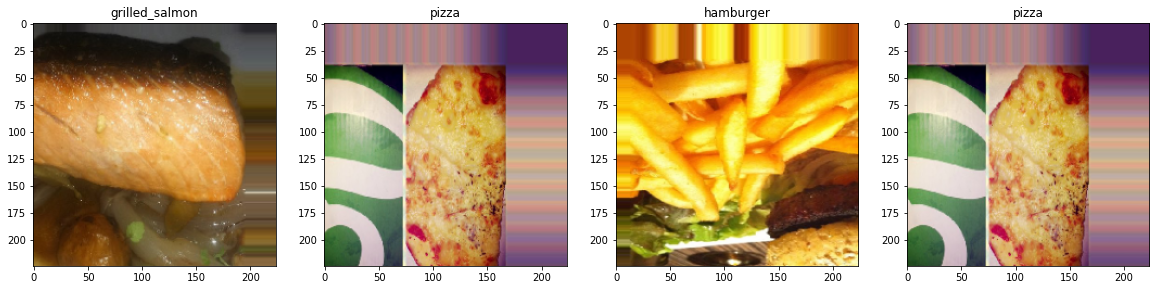

In [10]:
import matplotlib.pyplot as plt
import random

# Plot random images from the batch
IMAGE_COLS = 4
random_img_indices = [random.randint(0, len(img_batch)-1) for i in range(IMAGE_COLS)]

fig, axes = plt.subplots(1, IMAGE_COLS, figsize=(IMAGE_COLS*5, 5))
for i in range(IMAGE_COLS):
  axes[i].imshow(img_batch[random_img_indices[i]])
  axes[i].set_title(class_names[label_batch[random_img_indices[i]].argmax()])


In [11]:
# Reset data generator iterator
train_data_aug = train_data_gen_aug.flow_from_directory(directory=train_dir, 
                                                        target_size=(224, 224), 
                                                        class_mode='categorical',
                                                        batch_size=32, 
                                                        seed=42)

Found 750 images belonging to 10 classes.


## Create, compile, and fit the model

In [12]:
# Create tensorboard callback
import datetime
import tensorflow as tf
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving TensorBoard log files to {log_dir}')
  return tensorboard_callback

In [13]:
# Create model using TensorFlow Hub and compare two model
resnet_url = 'https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [14]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.activations import softmax

In [15]:
# Make a create_model function to create model from a url
def create_model(model_url, model_name, num_classes=10):
  """
  Takes a tensorflow hub url and creates keras.Sequential model.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.
  
  Returns:
    An uncompiled keras.Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons
  """
  # Download the pretrained model and save as keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,  # Freeze the already learned patterns
                                           name='feature_extraction_layer')
  # Create the model
  model = tf.keras.models.Sequential(name=model_name)
  # Add the input layer
  model.add(InputLayer(input_shape=(224, 224, 3)))
  # Add feature extarction layer
  model.add(feature_extractor_layer)
  # Add output layer
  model.add(Dense(units=num_classes, activation=softmax))
  # Print the model summary
  model.summary()
  
  return model
  

In [16]:
# Create the resnet model
resnet_model = create_model(resnet_url, 'resnet_model', 
                            num_classes=train_data_aug.num_classes)

Model: "resnet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
# Compile the resent model
resnet_model.compile(optimizer=Adam(),
                     loss=CategoricalCrossentropy(),
                     metrics=[categorical_accuracy])

In [18]:
# Fit the resent model
resnet_history = resnet_model.fit(train_data_aug, 
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name='resnet50V2')],
                                  epochs=5,
                                  validation_data=test_data,
                                  verbose=1)

Saving TensorBoard log files to tensorflow_hub/resnet50V2/20210712-151112
Epoch 1/5
24/24 [==============================] - 489s 21s/step - loss: 2.0081 - categorical_accuracy: 0.3147 - val_loss: 1.2713 - val_categorical_accuracy: 0.5908
Epoch 2/5
24/24 [==============================] - 436s 19s/step - loss: 1.2297 - categorical_accuracy: 0.5813 - val_loss: 0.9634 - val_categorical_accuracy: 0.6872
Epoch 3/5
24/24 [==============================] - 488s 21s/step - loss: 0.9901 - categorical_accuracy: 0.6760 - val_loss: 0.7914 - val_categorical_accuracy: 0.7464
Epoch 4/5
24/24 [==============================] - 437s 19s/step - loss: 0.8449 - categorical_accuracy: 0.7347 - val_loss: 0.7391 - val_categorical_accuracy: 0.7600
Epoch 5/5
24/24 [==============================] - 436s 19s/step - loss: 0.7556 - categorical_accuracy: 0.7453 - val_loss: 0.6944 - val_categorical_accuracy: 0.7744


In [30]:
import pandas as pd
# plot the validation and training curves
def plot_validation_and_training_curves(history):
  """
  Plots the validation and training loss and metrics curve of the model history

  Args:
    history: Tensorflow history object

  Returns:
    plots of training/validation loss and accuracy metrics
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['categorical_accuracy']
  val_accuracy = history.history['val_categorical_accuracy']

  epochs = range(len(loss))

  # plot the loss
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot binary_accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='Training Accuracy')
  plt.plot(epochs, val_accuracy, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

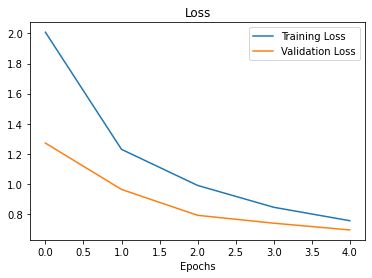

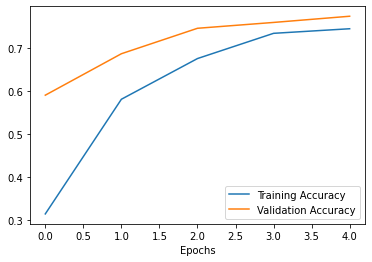

In [31]:
plot_validation_and_training_curves(resnet_history)

In [39]:
efficientnet_model = create_model(model_url=efficientnet_url,
                                  model_name='efficientnet_model',
                                  num_classes=train_data_aug.num_classes)

# Compile the EfficientNet model
efficientnet_model.compile(optimizer=Adam(),
                           loss=CategoricalCrossentropy(),
                           metrics=[categorical_accuracy])

# Fit the EfficientNet model top 10 percent of the training data
efficientnet_model.fit(train_data_aug, 
                       epochs=5, 
                       callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub', 
                                                              experiment_name='efficientnetb0')], 
                       validation_data=test_data)

Model: "efficientnet_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________
Saving TensorBoard log files to tensorflow_hub/efficientnetb0/20210712-165219
Epoch 1/5
24/24 [==============================] - 196s 8s/step - loss: 1.9869 - categorical_accuracy: 0.3640 - val_loss: 1.4858 - val_categorical_accuracy: 0.6568
Epoch 2/5
24/24 [==============================] - 165s 7s/step - loss: 1.3212 - categorical_accuracy: 0.6840 - val_loss: 1.0279 - val_categorical_accuracy: 0.7756
Epoch 3/5
24/24 [==============================] - 185s 8s/step - loss: 1.0292 - categori

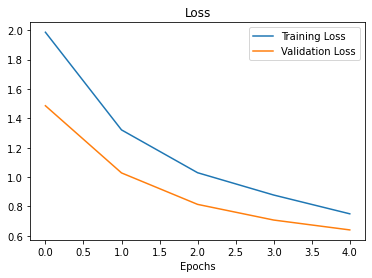

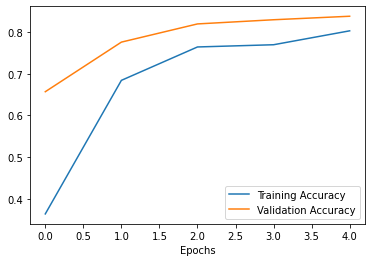

In [44]:
plot_validation_and_training_curves(efficientnet_model.history)

In [47]:
# Upload tensorboard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
--name "EffectiveNetB0 vs ResNetB2" \
--description "Comparng two different TF Hub feature extarction model architevtures using 10 percent of the training data" \
--one_shot

2021-07-12 18:25:17.973809: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/pQ77SE3eRRe6VR1wo1uBlQ/

[2021-07-12T18:25:19] Started scanning logdir.
[2021-07-12T18:25:21] Total uploaded: 60 scalars, 0 tensors, 2 binary objects (5.7 MB)
[2021-07-12T18:25:21] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/pQ77SE3eRRe6VR1wo1uBlQ/


In [46]:
# Check out what tensorboard experiments we have
!tensorboard dev list

2021-07-12 18:24:47.209424: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/mdrtkLKnSQGURUKJDgam0A/
	Name                 EffectiveNetB0 vs ResNetB2
	Description          Comparng two different TF Hub feature extarction model architevtures using 10 percent of the training data
	Id                   mdrtkLKnSQGURUKJDgam0A
	Created              2021-07-12 18:14:55 (9 minutes ago)
	Updated              2021-07-12 18:14:58 (9 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5976846
Total: 1 experiment(s)


In [48]:
# Delete an experiment
# !tensorboard dev delete --experiment_id mdrtkLKnSQGURUKJDgam0A